Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats.

As players progress through the levels of the game, they will **occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress**. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

***But where should the gates be placed? Initially, the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.***

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?
* When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np
import pandas as pd 
from scipy.stats import norm
import math as mt
np.set_printoptions(suppress=True)
import statsmodels.stats.api as sms
from scipy.stats import norm
import scipy.stats as stats
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import  plot_mpl #init_notebook_mode,


Defining some utility function to calculate standard deviation of proportions, z-score, comparing two proportions

In [2]:
def sample_sd_when_population_sd_is_not_given(p,n):
    sd = np.sqrt((p*(1-p))/n)
    return round(sd,4)

#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

def ztest_comparing_two_proportions(X1,X2,n1,n2):
    p1_hat = X1/n1
    p2_hat = X2/n2
    p_bar = (X1+X2)/(n1+n2)
    q_bar = (1-p_bar)
    z_numerator= p1_hat-p2_hat
    z_denominator = np.sqrt((1/n1+1/n2)*p_bar*q_bar)
    z_statistic = z_numerator/z_denominator
    p_value = norm().cdf(z_statistic)
    return z_numerator, p_value,z_denominator,z_statistic

# Reading in the data and columns

In [3]:
data = pd.read_csv('cookie_cats.csv')
print(data.info())
print(data['version'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


# **Control and Treatment Groups**

In an A/B/C../N testing experiment, we are looking to see whether one or more **explanatory variables**, e.g., change in the color of the button, change in the fonts on the webpage, affect the **response variable**. That is the metrics we selected to measure like conversion rate, retention rate, or people buying more stuff.

The people are assigned into at least two different groups, using proper **random sampling** techniques like cluster sampling, stratified sampling depending upon the use case. That way, the groups aren’t biased.

One group acts as the **control group**, which is the group that does nothing, receives nothing, or isn’t changed the way they are working. The other group is called the **treatment group** (also called the experimental group), a group that does something, receives something, or gets a new feature that we are trying to launch. The classic example of this is in medical studies, where the treatment group receives some new drug, and the control group receives a placebo, or sugar pill.

In [4]:
gate_30 = data[data['version']=='gate_30']  #control
gate_40 = data[data['version']=='gate_40']  #Treatment
print(gate_30.head())
print(gate_40.head())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


#  **Null Hypothesis and Alternate hypothesis: What question do we want to answer?**


### 1-Day Retention

**did the 1-Day Retention rate increased after moving the gate to level 40?**

**h0** = gate40<=gate30 

**ha** = gate40>30

### 7-Day Retention

**did the 7-Day Retention rate increased after moving the gate to level 40?**

**h0** = gate40<=gate30 

**ha** = gate40>30

# **Invariate Matrix**

- Invariate metrics are used for "sanity checks", that is, to make sure our experiment (the way we presented a change to a part of the population, as well as the way we collected the data) is not inherently wrong.
- we pick metrics that we consider not to change (not to be affected) because of our experiment and later make sure these metrics don't change drastically between our control and experiment groups.

sum_gamerounds is the invariate metric which we expect to be same between control and treatment group

# **Evaluation Metrics What is your success metric?**

- Evaluation metrics are the metrics in which we expect to see a change, and are relevant to the business goals we aim to achieve.
- For each metric, we state a **Minimum Detectable Effect:** - which marks the minimum change which is practically significant to the business. For instance, stating that any increase in retention that is under `1%`, even if statistically significant, is not practical to the business.

> Retention-1 Day
> Baseline Retention-1 Day: 0.448
> Minimum Detectable Effect: 0.01
> alpha: 5%
> beta: 20%
> 1-beta: 80%
> Number of groups = 2 (control and Treatment)
> sample size = 45489 Treatment/group
> total sample size = 90,189 enrollments

> Retention-7 Day
> Baseline Retention-7 Day: 0.19018
> Minimum Detectable Effect: 0.01
> alpha: 5%
> beta: 20%
> 1 - beta: 80%
> Number of groups = 2 (control and Treatment)
> sample size = 45489 Treatment/group
> total sample size = 90,189 enrollments
> 

# **Exploring Data Distribution of the Invariate Matrix between Control and Treatment Group**
We expect this metric to be same between the two groups to ensure the data collection is not biased

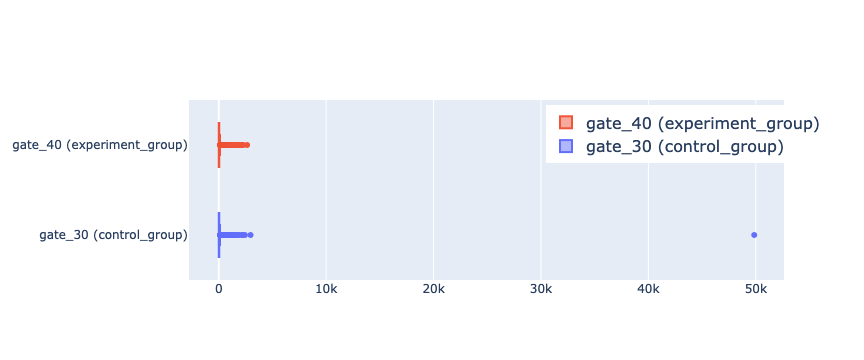

In [6]:
x0 = gate_30['sum_gamerounds']
x1 = gate_40['sum_gamerounds'] 
fig = go.Figure()
fig.add_trace(go.Box(x=x0, name='gate_30 (control_group)'))
fig.add_trace(go.Box(x=x1, name='gate_40 (experiment_group)'))
fig.update_layout(legend=dict(x=.6,y=0.97, traceorder='reversed', font_size=16))
fig.show()

**Removing the outlier since it can severly affect the distribution and statics**

In [7]:
gate_30=gate_30[gate_30['sum_gamerounds']!=gate_30['sum_gamerounds'].max()]
x0 = gate_30['sum_gamerounds']
x1 = gate_40['sum_gamerounds'] 

fig = go.Figure()
fig.add_trace(go.Box(x=x0, name='gate_30 (control_group)'))
fig.add_trace(go.Box(x=x1, name='gate_40 (experiment_group)'))
fig.update_layout(legend=dict(x=.6,y=0.97, traceorder='reversed', font_size=16))
fig.show()

**Invariate Matrix distribution across Control and Treatment Group**

In [9]:
gameround_gate_40 = gate_40['sum_gamerounds'].value_counts()
gameround_gate_40=gameround_gate_40.sort_values(ascending=False)
gameround_gate_30 = gate_30['sum_gamerounds'].value_counts()
gameround_gate_30=gameround_gate_30.sort_values(ascending=False)

In [12]:
# pd.set_option("max_rows", None)
pd.options.display.max_rows = None 
pd.set_option('display.max_columns', None)

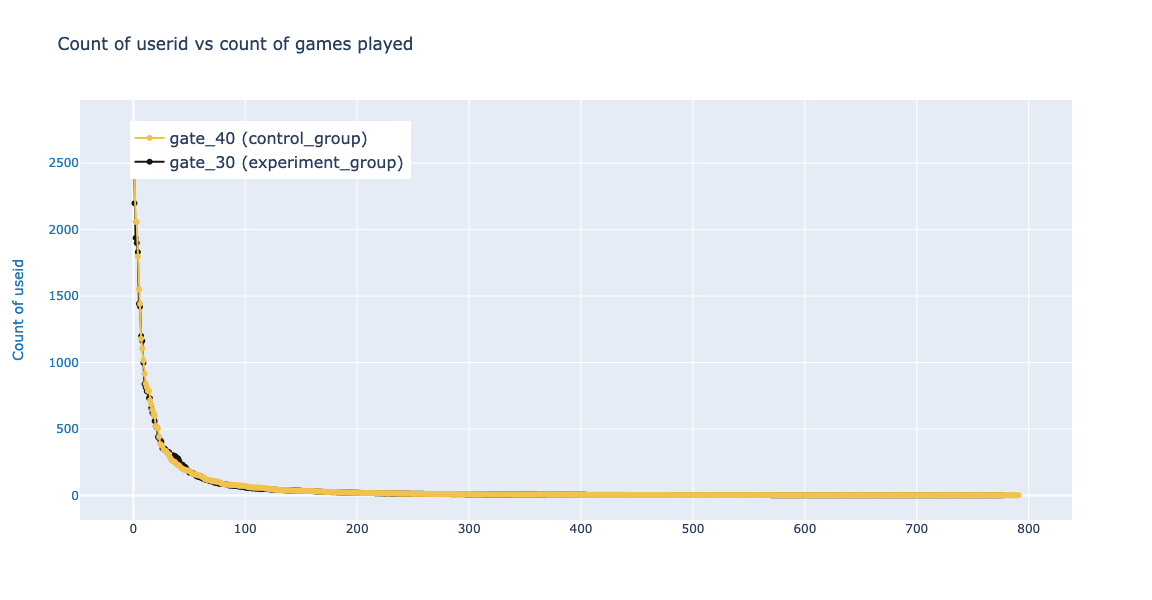

In [13]:
import warnings
warnings.filterwarnings('ignore')
colors=['#151515','#f0c24f']
fig = go.Figure()
fig.add_trace(go.Scatter(y=gameround_gate_30, mode='lines+markers',marker_color=colors[0], name='gate_30 (experiment_group)'))
fig.add_trace(go.Scatter(y=gameround_gate_40, mode='lines+markers',marker_color=colors[1], name='gate_40 (control_group)'))
fig.update_layout(title="Count of userid vs count of games played", 
                 legend=dict(x=.05,y=0.95, traceorder='reversed', font_size=16), width=600,height=600,
                 yaxis=dict(title="Count of useid",titlefont=dict(
                          color="#1f77b4"),tickfont=dict(color="#1f77b4")))
fig.show()

**Normal Approximation of sum_gamerounds**
“How many gamerounds were played by userids in each group”. We can invoke the Central Limit Theorem. As we’re interested in the average conversion, or average time spent on the site, this averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution.

**Two sample z-test for the difference between means**

> **Null Hypothesis** = gate_40_sum_gamerounds = gate_40_sum_gamerounds

> **Alternate Hypothesis** = gate_40_sum_gamerounds != gate_40_sum_gamerounds

In [14]:
gate_30_mean= gate_30['sum_gamerounds'].mean()
gate_30_std=gate_30['sum_gamerounds'].std()
gate_40_mean= gate_40['sum_gamerounds'].mean()
gate_40_std=gate_40['sum_gamerounds'].std()
poopled_std = np.sqrt(((gate_30_std)**2/gate_30.shape[0]) + ((gate_40_std)**2/gate_40.shape[0]))
pooled_mean = gate_30_mean-gate_40_mean
z_score =  pooled_mean/poopled_std
p= norm().cdf(z_score)
print(f"Zscore is {z_score:0.2f}, p-value is {(1-p)*2:0.3f} (two tailed), {p:0.3f} (one tailed)")

Zscore is 0.06, p-value is 0.949 (two tailed), 0.525 (one tailed)


Welch t-Test (easier and direct way to do it)

In [15]:
from scipy.stats import ttest_ind
order_value_control_group = gate_30['sum_gamerounds'].to_list()
order_value_experimental_group = gate_40['sum_gamerounds'].to_list()
zscore, prob= ttest_ind(order_value_control_group, order_value_experimental_group, equal_var=False)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is 0.06, p-value is 0.949 (two tailed), 0.475 (one tailed)


# Conclusion on the Invariate Metric 
**Since the p-value is greater than 0.05 we fail to reject the null hypothesis and the two distributions seem to be same and hence we are good to proceed as this indicates there is no bias in the data between the control and treatment group**

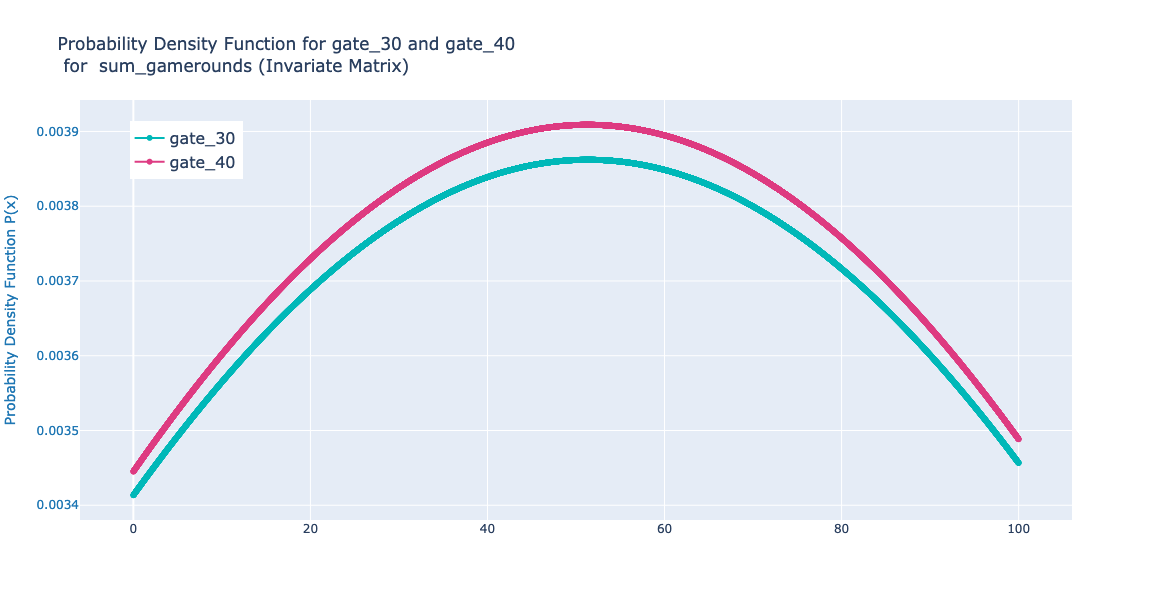

In [16]:
colors=['#de3d83','#00b8b8','#e4bd0b']
fig = go.Figure()
click_rate = np.linspace(0, 100, 10000)
prob_a = norm(gate_40_mean, gate_30_std).pdf(click_rate)
prob_b = norm(gate_30_mean, gate_40_std).pdf(click_rate)
fig.add_trace(go.Scatter(y=prob_a , x=click_rate, mode='lines+markers',marker_color=colors[0], name='gate_40'))
fig.add_trace(go.Scatter(y=prob_b , x=click_rate, mode='lines+markers',marker_color=colors[1], name='gate_30'))
fig.update_layout(title="Probability Density Function for gate_30 and gate_40 <br> for  sum_gamerounds (Invariate Matrix) ", 
                 legend=dict(x=.05,y=0.95, traceorder='reversed', font_size=16), 
                 width=600,
                 height=600,
                 yaxis=dict(
                          title="Probability Density Function P(x)",
                 titlefont=dict(
                          color="#1f77b4"
                                ),
                 tickfont=dict(
                        color="#1f77b4"
                               )
  ))
fig.show()

# Samples Needed to perform the experiment How many samples need to be in the experiment?

I used the control group probability as a proxy for the baseline significance level and set the practical significance level, confidence level and sensitivity to 1%, 95% and 80% respectively. Using these values I calculated the minimum sample size required for each test group to make sure there was sufficient data to draw statistically robust conclusions.

In [17]:
import statsmodels.stats.api as sms
baseline_cvr=0.448
alpha=0.05
power=0.8
mini_diff=0.01
effect_size=sms.proportion_effectsize(baseline_cvr, baseline_cvr+mini_diff)
sample_size=sms.NormalIndPower().solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
print('Required sample size for Retention Day 1 metric ~ {0:.1f}'.format(sample_size) + ' per group')

Required sample size for Retention Day 1 metric ~ 38896.2 per group


In [18]:
baseline_cvr_day7=0.19018
alpha_day7=0.05
power_day7=0.8
mini_diff_day7=0.01
effect_size_day7=sms.proportion_effectsize(baseline_cvr_day7, baseline_cvr_day7+mini_diff_day7)
sample_size_day7=sms.NormalIndPower().solve_power(effect_size=effect_size_day7, power=power_day7, alpha=alpha_day7, ratio=1)
print('Required sample size for Retention Day 7 metric ~ {0:.1f}'.format(sample_size_day7) + ' per group')

Required sample size for Retention Day 7 metric ~ 24655.1 per group


**Relationship between Minimum sample size required vs minimum detectable difference**


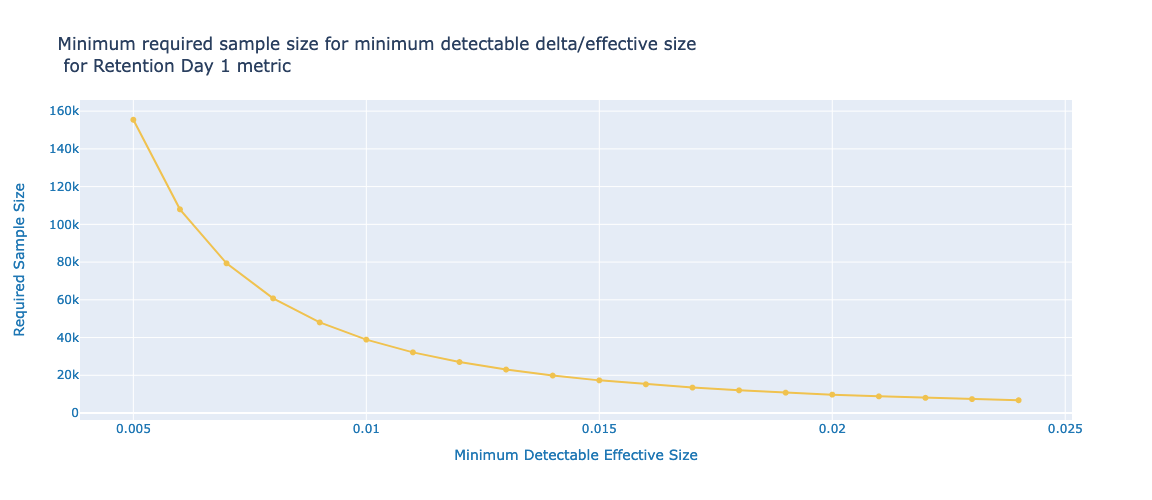

In [19]:
samplesize_list=[]
baseline=0.448
deltas=np.arange(0.005, 0.025, 0.001)
for delta in deltas:
  prob2=baseline+delta
  effect_size=sms.proportion_effectsize(baseline, prob2)
  sample_size=sms.NormalIndPower().solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=1)
  samplesize_list.append(sample_size)
colors=['#151515','#f0c24f']
fig = go.Figure()
fig.add_trace(go.Scatter(y=samplesize_list , x=deltas, mode='lines+markers',marker_color=colors[1]))
fig.update_layout(title="Minimum required sample size for minimum detectable delta/effective size <br> for Retention Day 1 metric", 
                 legend=dict(x=.05,y=0.95, traceorder='reversed', font_size=16), 
                 width=500,
                 height=500,
                 yaxis=dict(
                          title="Required Sample Size",
                 titlefont=dict(
                          color="#1f77b4"
                                ),
                 tickfont=dict(
                        color="#1f77b4"
                               )),
                xaxis=dict(
                          title="Minimum Detectable Effective Size",
                 titlefont=dict(
                          color="#1f77b4"
                                ),
                 tickfont=dict(
                        color="#1f77b4"
                               )
  ))
fig.show()

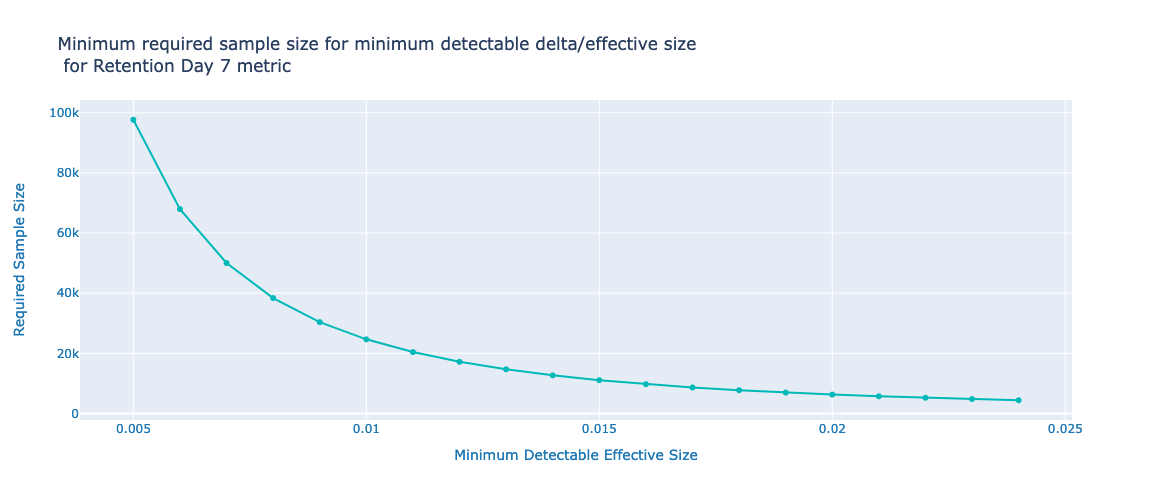

In [20]:
samplesize_list=[]
baseline=0.19018
deltas=np.arange(0.005, 0.025, 0.001)
for delta in deltas:
  prob2=baseline+delta
  effect_size=sms.proportion_effectsize(baseline, prob2)
  sample_size=sms.NormalIndPower().solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=1)
  samplesize_list.append(sample_size)
colors=['#00b8b8','#f0c24f']
fig = go.Figure()
fig.add_trace(go.Scatter(y=samplesize_list , x=deltas, mode='lines+markers',marker_color=colors[0]))
fig.update_layout(title="Minimum required sample size for minimum detectable delta/effective size <br> for Retention Day 7 metric", 
                 legend=dict(x=.05,y=0.95, traceorder='reversed', font_size=16), 
                 width=500,
                 height=500,
                 yaxis=dict(
                          title="Required Sample Size",
                 titlefont=dict(
                          color="#1f77b4"
                                ),
                 tickfont=dict(
                        color="#1f77b4"
                               )),
                xaxis=dict(
                          title="Minimum Detectable Effective Size",
                 titlefont=dict(
                          color="#1f77b4"
                                ),
                 tickfont=dict(
                        color="#1f77b4"
                               )
  ))
fig.show()

#  z-test for comparing two proportions 1-day retention

In [21]:
#1-day rretention
#h0 = gate40<=gate30
#ha = gate40>30
game_30_day1_retention = gate_30['retention_1'].sum()
game_40_day1_retention = gate_40['retention_1'].sum()
game_30_count=gate_30.shape[0]
game_40_count=gate_40.shape[0]
print(f'game_30 p1 {game_30_day1_retention/game_30_count:.3f}')
print(f'game_40 p2 {game_40_day1_retention/game_40_count:.3f}')
mean, p_value,me,z_statistic1 = ztest_comparing_two_proportions(game_40_day1_retention, game_30_day1_retention,game_40_count,game_30_count)
print(f'zscore for 1-day retention {z_statistic1:.3f}')
print(f'p-value for 1-day retention {1-p_value:.3f}')
print(f'Probablity that gate_40 increasted the 1-day retention (gate_40-gate_30>0) {p_value:.3f}')

game_30 p1 0.448
game_40 p2 0.442
zscore for 1-day retention -1.787
p-value for 1-day retention 0.963
Probablity that gate_40 increasted the 1-day retention (gate_40-gate_30>0) 0.037


zscore is -1.779, with p-value 0.962


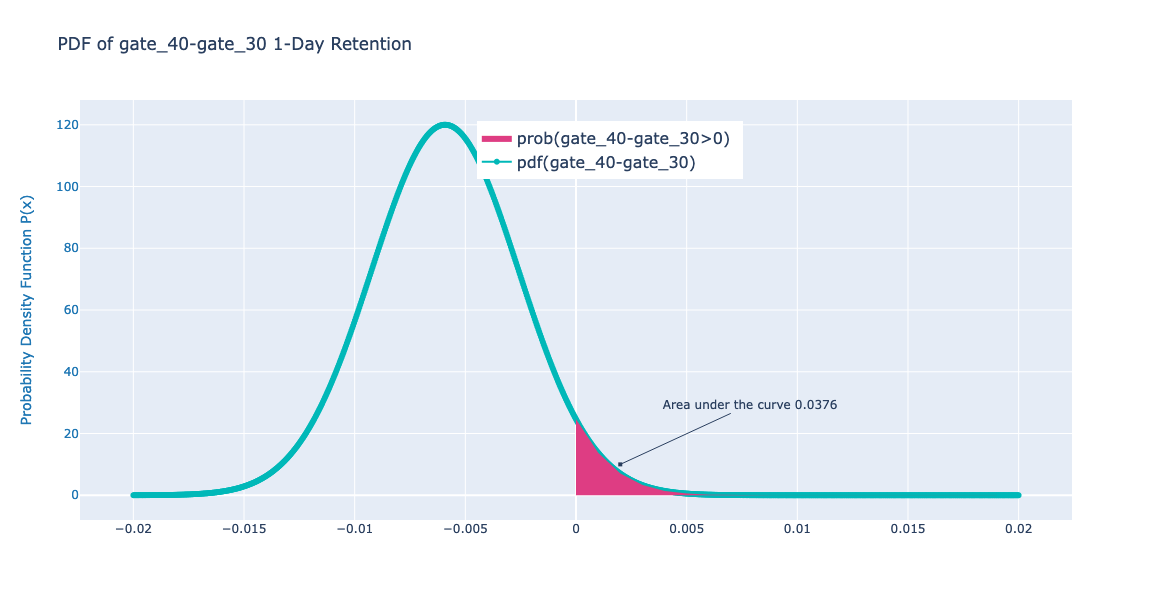

In [22]:
import plotly.graph_objects as go
fig = go.Figure()
colors=['#00b8b8','#de3d83']

rate_b=game_40_day1_retention/game_40_count
rate_a=game_30_day1_retention/game_30_count
std_a = sample_sd_when_population_sd_is_not_given(rate_a,game_30_count)
std_b=sample_sd_when_population_sd_is_not_given(rate_b,game_40_count)

p_hat_1day=rate_b - rate_a
p_hat_1day_std = np.sqrt(std_a**2 + std_b**2)

z_score = p_hat_1day / p_hat_1day_std
p = norm(p_hat_1day, p_hat_1day_std)
x = np.linspace(-0.02, 0.02, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)


print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

x_value = norm(loc=p_hat_1day,scale=p_hat_1day_std).isf(norm().sf(z_score))
px=np.arange(0.0,.02,0.00100)
fig.add_trace(go.Scatter(y=y , x=x, mode='lines+markers',marker_color=colors[0], name='pdf(gate_40-gate_30)'))
fig.add_trace(go.Scatter(
    y=norm.pdf(px,loc=p_hat_1day,scale=p_hat_1day_std), 
    x=px,  mode='lines',name="prob(gate_40-gate_30>0) ",
    fill='tozeroy',
    fillcolor=colors[1],
    line=dict(color='#f43530', width=.1))) # fill to trace0 y

fig.add_annotation(x=.002,y=10,
            text="Area under the curve {}".format(area_under_curve.round(4)))
fig.update_annotations(dict(xref="x",yref="y",showarrow=True, arrowhead=7,ax=130,ay=-60))

fig.update_layout(title="PDF of gate_40-gate_30 1-Day Retention", 
                 legend=dict(x=.40,y=0.95, traceorder='reversed', font_size=16),  width=600,height=600,yaxis=dict(title="Probability Density Function P(x)", titlefont=dict(color="#1f77b4"),tickfont=dict(color="#1f77b4")))
fig.show()

#  z-test for comparing two proportions 7-day retention

In [23]:
#7-day rretention
#h0 = gate40<=gate30
#ha = gate40>30
game_30_day7_retention = gate_30['retention_7'].sum()
game_40_day7_retention = gate_40['retention_7'].sum()
game_30_count=gate_30.shape[0]
game_40_count=gate_40.shape[0]
print(f'game_30_ret7 p1 {game_30_day7_retention/game_30_count:.4f}')
print(f'game_40_ret7 p2 {game_40_day7_retention/game_40_count:.4f}')
mean7, p_value7,me7,z_statistic7 = ztest_comparing_two_proportions(game_40_day7_retention, game_30_day7_retention,game_40_count,game_30_count)
print(f'zscore for 7-day retention {z_statistic7:.4f}')
print(f'p-value for 7-day retention {1-p_value7:.4f}')
print(f'Probablity that gate_40 increasted the 7-day retention (gate_40-gate_30>0) {p_value7:.3f}')

game_30_ret7 p1 0.1902
game_40_ret7 p2 0.1820
zscore for 7-day retention -3.1574
p-value for 7-day retention 0.9992
Probablity that gate_40 increasted the 7-day retention (gate_40-gate_30>0) 0.001


zscore is -3.127, with p-value 0.999


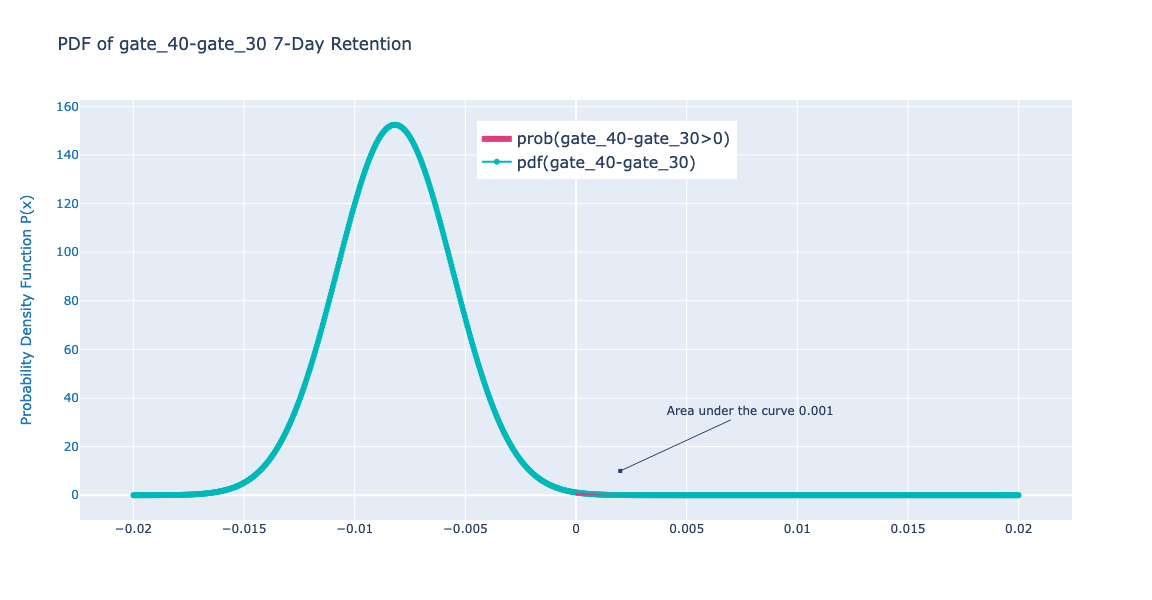

In [24]:
import plotly.graph_objects as go
fig = go.Figure()
colors=['#00b8b8','#de3d83']

rate_b_day7=game_40_day7_retention/game_40_count
rate_a_day7=game_30_day7_retention/game_30_count
std_a_day7 = sample_sd_when_population_sd_is_not_given(rate_a_day7,game_30_count)
std_b_day7=sample_sd_when_population_sd_is_not_given(rate_b_day7,game_40_count)


p_hat_day7=rate_b_day7 - rate_a_day7
p_std_hat_day7= np.sqrt(std_a_day7**2 + std_b_day7**2)


z_score_day7 = (p_hat_day7) / (p_std_hat_day7)
p_day7 = norm(p_hat_day7, (p_std_hat_day7))
x_day7 = np.linspace(-0.02, 0.02, 1000)
y_day7 = p_day7.pdf(x_day7)
area_under_curve_day7 = p_day7.sf(0)

print(f"zscore is {z_score_day7:0.3f}, with p-value {norm().sf(z_score_day7):0.3f}")

x_value_day7 = norm(loc=p_hat_day7,scale=p_std_hat_day7).isf(norm().sf(z_score_day7))
px_day7=np.arange(0.0,.02,0.00100)
fig.add_trace(go.Scatter(y=y_day7 , x=x_day7, mode='lines+markers',marker_color=colors[0], name='pdf(gate_40-gate_30)'))
fig.add_trace(go.Scatter(
    y=norm.pdf(px_day7,loc=p_hat_day7,scale=p_std_hat_day7), 
    x=px_day7,  mode='lines',name="prob(gate_40-gate_30>0)",
    fill='tozeroy',
    fillcolor=colors[1],
    line=dict(color='#f43530', width=.1))) # fill to trace0 y

fig.add_annotation(x=.002,y=10,
            text="Area under the curve {}".format(area_under_curve_day7.round(3)))
fig.update_annotations(dict(xref="x",yref="y",showarrow=True, arrowhead=7,ax=130,ay=-60))

fig.update_layout(title="PDF of gate_40-gate_30 7-Day Retention", 
                 legend=dict(x=.40,y=0.95, traceorder='reversed', font_size=16),  width=600,height=600,yaxis=dict(title="Probability Density Function P(x)", titlefont=dict(color="#1f77b4"),tickfont=dict(color="#1f77b4")))
fig.show()

# Conclusions and Recommendation of the ab-test

- **Retention Day-1, The probability that the 1-Day retention will increase by moving the gate level to 40  is 0.037 and hence we will not recommend moving the gate**
- **Retention Day-7, The probability that the 7-Day retention will increase by moving the gate level to 40  is 0.001 and hence we will not recommend moving the gate**